With Preprocessed_EEG

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import mne
import pandas as pd

In [2]:

file_path = 'E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/Practice with datasets/Seed/Preprocessed_EEG/2_20140404.mat'

mat_data = sio.loadmat(file_path)


In [3]:
#Explore Variable Names

variable_names = mat_data.keys()
print(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'jl_eeg1', 'jl_eeg2', 'jl_eeg3', 'jl_eeg4', 'jl_eeg5', 'jl_eeg6', 'jl_eeg7', 'jl_eeg8', 'jl_eeg9', 'jl_eeg10', 'jl_eeg11', 'jl_eeg12', 'jl_eeg13', 'jl_eeg14', 'jl_eeg15'])


In [23]:
print(mat_data['__header__'])
print(mat_data['__version__'])
print(mat_data['__globals__'])

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Apr 05 19:54:42 2014'
1.0
[]


In [4]:
for trial_index in range(1, 16):  # Assuming trial indices are from 1 to 15
    # Replace 'djc_eeg1' with the corresponding variable name containing EEG data for each trial
    variable_name = f'jl_eeg{trial_index}'
    eeg_data = mat_data[variable_name]

    # Print the shape of the EEG data for this trial
    print(f"Shape of EEG data for trial {trial_index}: {eeg_data.shape}")

Shape of EEG data for trial 1: (62, 47001)
Shape of EEG data for trial 2: (62, 46601)
Shape of EEG data for trial 3: (62, 41201)
Shape of EEG data for trial 4: (62, 47601)
Shape of EEG data for trial 5: (62, 37001)
Shape of EEG data for trial 6: (62, 39001)
Shape of EEG data for trial 7: (62, 47401)
Shape of EEG data for trial 8: (62, 43201)
Shape of EEG data for trial 9: (62, 53001)
Shape of EEG data for trial 10: (62, 47401)
Shape of EEG data for trial 11: (62, 47001)
Shape of EEG data for trial 12: (62, 46601)
Shape of EEG data for trial 13: (62, 47001)
Shape of EEG data for trial 14: (62, 47601)
Shape of EEG data for trial 15: (62, 41201)


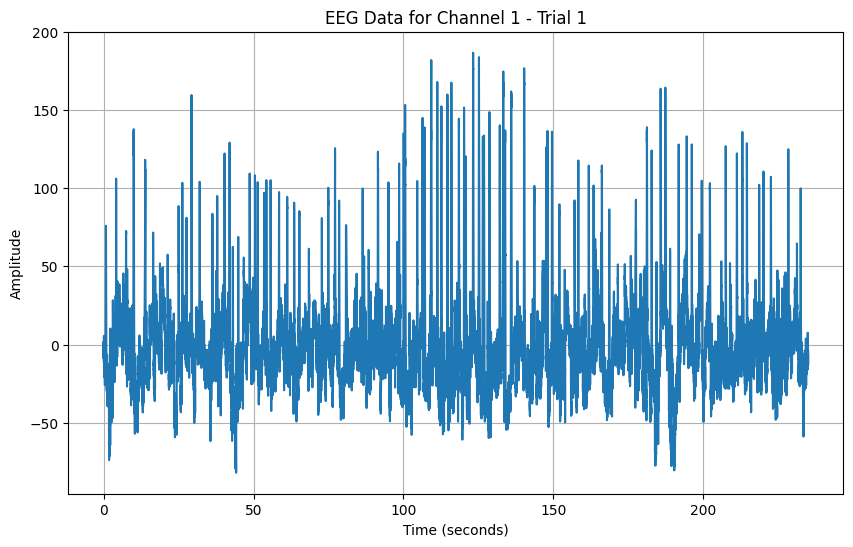

In [5]:
# Choose the channel index for plotting (0 for the first channel, 1 for the second channel, and so on)
channel_index = 0
eeg_trial_data = mat_data['jl_eeg1']
# Get the EEG data for the chosen channel
eeg_channel_data = eeg_trial_data[channel_index, :]

# Create a time vector for the x-axis (assuming a sampling rate of 200 Hz as mentioned in the dataset description)
sampling_rate = 200
time_vector = np.arange(len(eeg_channel_data)) / sampling_rate

# Plot the EEG data for the chosen channel
plt.figure(figsize=(10, 6))
plt.plot(time_vector, eeg_channel_data)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'EEG Data for Channel {channel_index + 1} - Trial 1')
plt.grid(True)
plt.show()


# PSD 

In [35]:
# Create MNE Raw object
info = mne.create_info(ch_names=[f'Channel {i + 1}' for i in range(eeg_trial_data.shape[0])], sfreq=200, ch_types='eeg')
raw = mne.io.RawArray(eeg_trial_data, info)

# Define frequency bands
freq_bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 50)}

# Calculate PSD Features using Welch method
psds, freqs = mne.time_frequency.psd_array_welch(raw.get_data(), sfreq=raw.info['sfreq'], fmin=0.5, fmax=50, n_jobs=1)

# Organize PSD Features into DataFrame
psd_data = []

# Iterate through frequency bands
for band, (fmin, fmax) in freq_bands.items():
    band_data = []

    # Iterate through channels
    for channel_idx, channel_name in enumerate(info.ch_names):
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        avg_psd = np.mean(psds[channel_idx, freq_mask])
        band_data.append(avg_psd)

    # Append channel's PSD features to the data list
    psd_data.extend(band_data)

print(psd_data)
# Create a DataFrame
column_names = [f'{channel_name}_{band}' for channel_name in info.ch_names for band in freq_bands.keys()]
df = pd.DataFrame(data=[psd_data], columns=column_names)

# Print the DataFrame
#print(df)


Creating RawArray with float64 data, n_channels=62, n_times=47001
    Range : 0 ... 47000 =      0.000 ...   235.000 secs
Ready.
Effective window size : 1.280 (s)
[133.75401558956497, 128.03891344650745, 116.40641436995125, 43.718453769686356, 36.938371823131334, 116.2961657884752, 28.10645033246459, 12.805883910852657, 12.760210768078954, 10.514077152994815, 10.548243601150105, 10.960122208686322, 20.639158516928724, 45.02001312967599, 30.419757865706007, 16.25882035452639, 5.850981255575123, 3.813686844835608, 2.559570802003064, 2.6952736536392834, 4.683907407664063, 12.782113898528085, 28.991428683753398, 18.445359157923768, 9.085993482919932, 3.50954751727082, 0.9785066423268979, 0.014616739813639893, 0.5838934962828574, 4.219866683684085, 8.677060961564116, 16.76266999481237, 11.672959239560367, 6.12600115876732, 2.44393573578438, 1.0329875593220954, 0.01492634917349009, 0.8513233066508292, 2.403765490993075, 6.324320789042673, 10.687116169922707, 11.294179621341305, 7.48555376745

In [40]:
def calculate_psd_features(eeg_trial_data):
    # Create MNE Raw object
    info = mne.create_info(ch_names=[f'Channel {i + 1}' for i in range(eeg_trial_data.shape[0])], sfreq=200, ch_types='eeg')
    raw = mne.io.RawArray(eeg_trial_data, info)

    # Define frequency bands
    freq_bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 50)}

    # Calculate PSD Features using Welch method
    psds, freqs = mne.time_frequency.psd_array_welch(raw.get_data(), sfreq=raw.info['sfreq'], fmin=0.5, fmax=50, n_jobs=1)

    # Organize PSD Features into DataFrame
    psd_data = []

    # Iterate through frequency bands
    for band, (fmin, fmax) in freq_bands.items():
        band_data = []

        # Iterate through channels
        for channel_idx, channel_name in enumerate(info.ch_names):
            freq_mask = (freqs >= fmin) & (freqs <= fmax)
            avg_psd = np.mean(psds[channel_idx, freq_mask])
            band_data.append(avg_psd)

        # Append channel's PSD features to the data list
        psd_data.extend(band_data)

    return psd_data

# Example usage:
# psd_data = calculate_psd_features(eeg_trial_data)
# print(psd_data)


In [59]:
def process_subject_mat_files(mat_folder):
    freq_bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 50)}
    subject_psd_data = []

    # Iterate through mat files in the folder
    for filename in os.listdir(mat_folder):
        if filename.endswith(".mat"):
            mat_file = os.path.join(mat_folder, filename)

            # Load the mat file
            mat_content = scipy.io.loadmat(mat_file)

            # Identify trials in the mat file
            trial_names = [key for key in mat_content.keys() if 'eeg' in key.lower()]
            trial_names.sort()
            # Iterate through trials
            for trial_name in trial_names:
                eeg_trial_data = mat_content[trial_name]
                psd_features = calculate_psd_features(eeg_trial_data)
                subject_psd_data.append(psd_features)
    
    column_names = [f'channel_{i}_{band}' for i in range(62) for band in freq_bands.keys()]
    df = pd.DataFrame(data=np.array(subject_psd_data), columns=column_names)

    
    return df



In [60]:
mat_folder = "E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/Practice with datasets/Seed/Preprocessed_EEG"
subject_psd_data = process_subject_mat_files(mat_folder)

Creating RawArray with float64 data, n_channels=62, n_times=47001
    Range : 0 ... 47000 =      0.000 ...   235.000 secs
Ready.
Effective window size : 1.280 (s)
Creating RawArray with float64 data, n_channels=62, n_times=47401
    Range : 0 ... 47400 =      0.000 ...   237.000 secs
Ready.
Effective window size : 1.280 (s)
Creating RawArray with float64 data, n_channels=62, n_times=47001
    Range : 0 ... 47000 =      0.000 ...   235.000 secs
Ready.
Effective window size : 1.280 (s)
Creating RawArray with float64 data, n_channels=62, n_times=46601
    Range : 0 ... 46600 =      0.000 ...   233.000 secs
Ready.
Effective window size : 1.280 (s)
Creating RawArray with float64 data, n_channels=62, n_times=47001
    Range : 0 ... 47000 =      0.000 ...   235.000 secs
Ready.
Effective window size : 1.280 (s)
Creating RawArray with float64 data, n_channels=62, n_times=47601
    Range : 0 ... 47600 =      0.000 ...   238.000 secs
Ready.
Effective window size : 1.280 (s)
Creating RawArray with

In [55]:
subject_psd_data.shape

(30, 310)

In [58]:
subject_psd_data.head()

,channel_0_delta,channel_0_theta,channel_0_alpha,channel_0_beta,channel_0_gamma,channel_1_delta,channel_1_theta,channel_1_alpha,channel_1_beta,channel_1_gamma,...,channel_60_delta,channel_60_theta,channel_60_alpha,channel_60_beta,channel_60_gamma,channel_61_delta,channel_61_theta,channel_61_alpha,channel_61_beta,channel_61_gamma
0,151.761753,140.103556,135.821030,57.546267,48.765136,105.625168,37.469691,20.662526,14.989260,12.151366,...,0.148085,0.089088,0.122542,12929.385864,0.523258,0.710669,0.566447,0.268231,0.214262,0.195238
1,221.985420,207.570899,201.253253,85.006936,70.076321,376.459245,57.575279,30.790129,21.831946,17.489631,...,0.179611,0.099016,0.154036,99411.811384,0.556977,1.161855,0.827118,0.334716,0.311854,0.289642
2,150.244008,144.525913,145.000126,57.608473,51.504297,318.260798,40.100752,21.109848,15.158482,12.995876,...,0.113547,0.074127,0.107916,99389.451914,0.326249,0.609443,0.449566,0.244761,0.247501,0.248170
3,161.931320,151.890108,144.587309,62.905725,50.289912,564.938347,43.470552,22.892416,16.665629,13.651681,...,0.113309,0.066728,0.088432,96822.736966,0.333633,0.617128,0.456924,0.224101,0.157413,0.149834
4,130.603259,122.207883,117.894659,50.354839,42.269319,469.924648,37.862057,18.132463,13.439139,11.102117,...,0.139576,0.078573,0.101031,130396.274570,0.393610,0.890892,0.620245,0.276692,0.185274,0.178883
